# Urban Area Long-Term Analysis and Prediction

This notebook performs an advanced analysis of an urban area dataset using various data preprocessing techniques, visualization, PCA, and LSTM for future trend prediction. We will analyze historical data and predict future built-up area trends for BCE and AD periods.

## Importing necessary libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
import cv2
import tensorflow as tf

## Load and Preprocess Data

We will start by loading the dataset and preprocessing it to handle missing values, convert data types, and create new features.

In [2]:
file_path = 'data/urban-area-long-term new.csv'
data = pd.read_csv(file_path)

data['Land use: Built-up area'] = data['Land use: Built-up area'].astype(str).str.replace(',', '.')
data['Land use: Built-up area'] = pd.to_numeric(data['Land use: Built-up area'], errors='coerce')

data.isnull().sum()

data.dropna(inplace=True)

data['Year'] = pd.to_numeric(data['Year'], errors='coerce')

data = data.dropna()

data['Built-up Area per Year'] = data['Land use: Built-up area'] / data['Year'].abs()

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=['Built-up Area per Year'], inplace=True)

data = data[np.isfinite(data['Built-up Area per Year'])]

max_value = data['Built-up Area per Year'].quantile(0.99)
data['Built-up Area per Year'] = np.clip(data['Built-up Area per Year'], None, max_value)

assert not np.isinf(data['Built-up Area per Year']).any(), "There are infinite values in the data"
assert data['Built-up Area per Year'].max() <= max_value, "There are values larger than the cap in the data"

## Exploratory Data Analysis
Let's visualize the distribution of built-up area over the years and across different countries.

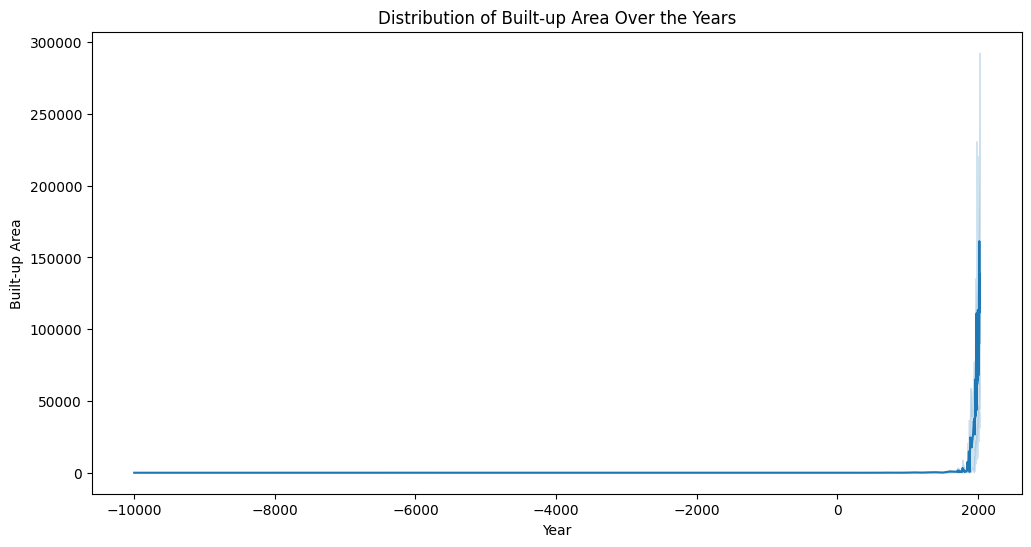

In [3]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Land use: Built-up area', data=data)
plt.title('Distribution of Built-up Area Over the Years')
plt.xlabel('Year')
plt.ylabel('Built-up Area')
plt.show()

## Distribution of built-up area across different countries

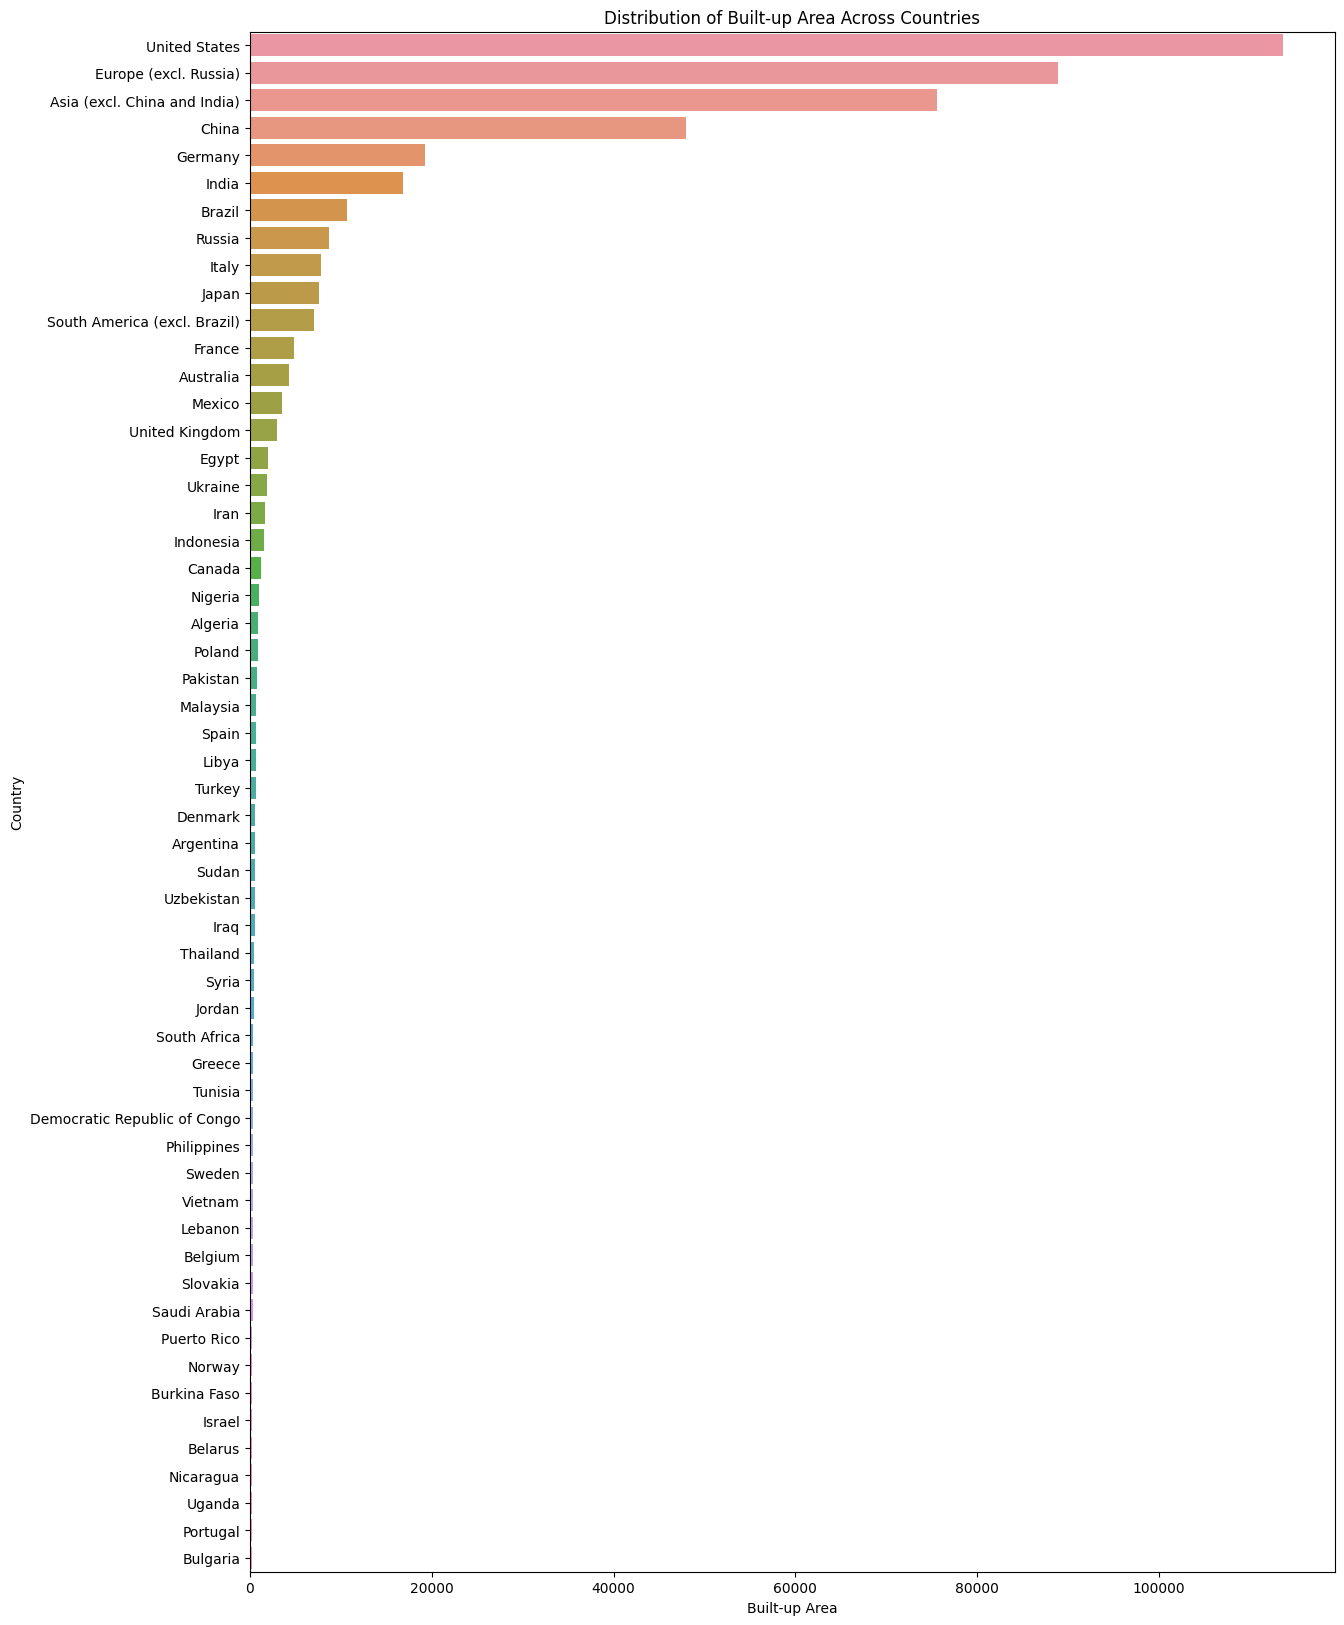

In [4]:
data['Land use: Built-up area'] = data['Land use: Built-up area'].astype(str).str.replace(',', '.')
data['Land use: Built-up area'] = pd.to_numeric(data['Land use: Built-up area'], errors='coerce')
data.dropna(inplace=True)

country_data = data.groupby('country')['Land use: Built-up area'].mean().reset_index()

continents_and_world = ['World', 'Asia', 'Europe', 'Africa', 'North America', 'South America', 'Oceania']
country_data = country_data[~country_data['country'].isin(continents_and_world)]
country_data = country_data[country_data['Land use: Built-up area'] > 0]

bulgaria_value = country_data[country_data['country'] == 'Bulgaria']['Land use: Built-up area'].values[0]

country_data = country_data[country_data['Land use: Built-up area'] >= bulgaria_value]
country_data = country_data.sort_values(by='Land use: Built-up area', ascending=False)

plt.figure(figsize=(14, 20)) 
sns.barplot(x='Land use: Built-up area', y='country', data=country_data, orient='h')
plt.title('Distribution of Built-up Area Across Countries')
plt.xlabel('Built-up Area')
plt.ylabel('Country')
plt.show()

## Feature Engineering
We will create additional features to enhance our analysis.

In [5]:
data['Built-up Area per Year'] = data['Land use: Built-up area'] / data['Year']

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=['Built-up Area per Year'], inplace=True)

data = data[np.isfinite(data['Built-up Area per Year'])]

max_value = data['Built-up Area per Year'].quantile(0.99)
data['Built-up Area per Year'] = np.clip(data['Built-up Area per Year'], None, max_value)

assert not np.isinf(data['Built-up Area per Year']).any(), "There are infinite values in the data"
assert data['Built-up Area per Year'].max() <= max_value, "There are values larger than the cap in the data"

## Principal Component Analysis (PCA)
We will use PCA to reduce the dimensionality of the dataset and visualize the main components.

In [7]:
from sklearn.preprocessing import StandardScaler
features = ['Land use: Built-up area', 'Built-up Area per Year']
x = data[features]
y = data['Year']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Year'] = y.values

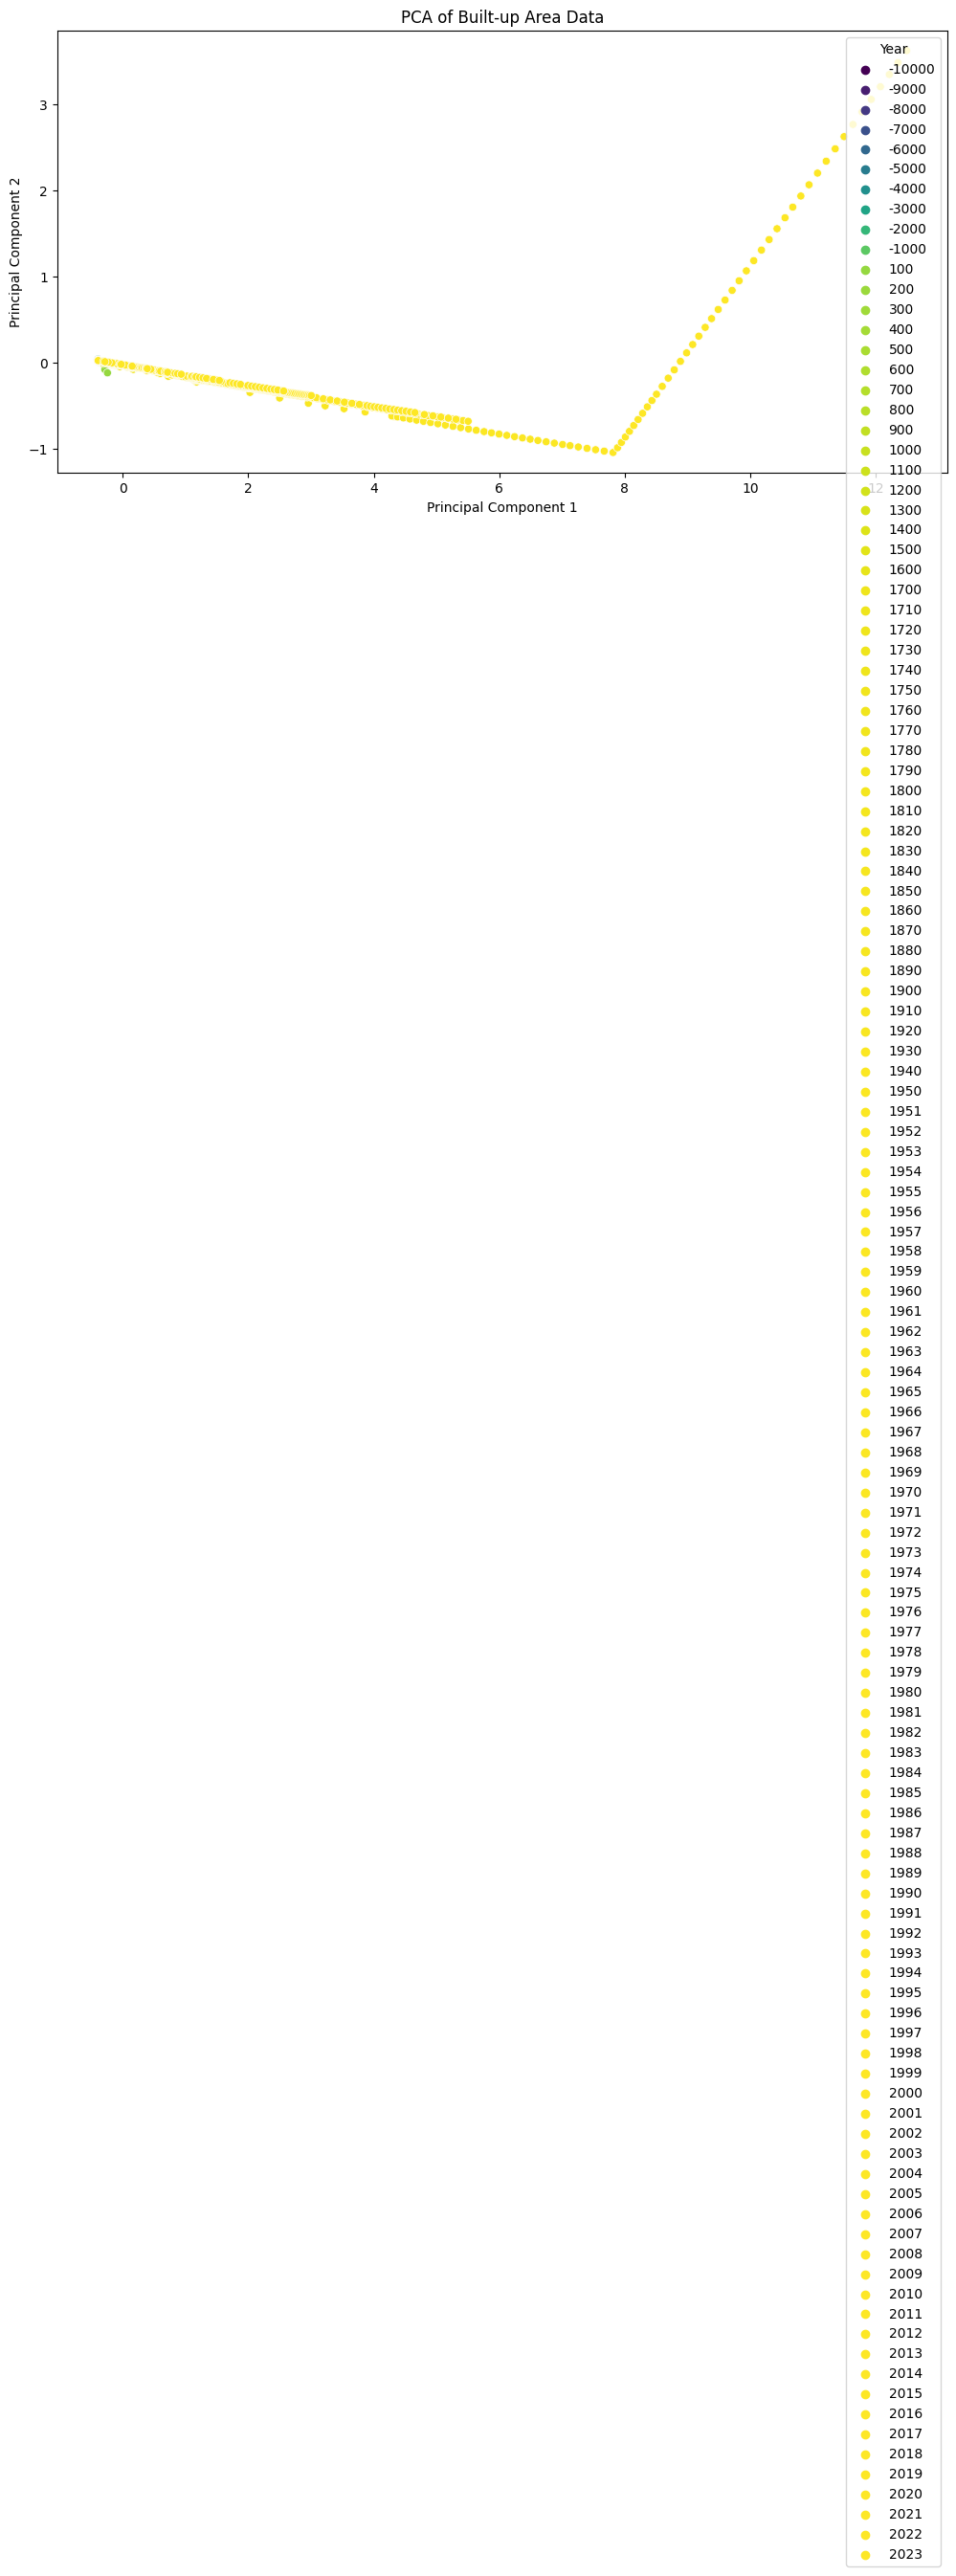

In [8]:
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(x='PC1', y='PC2', hue='Year', data=pca_df, palette='viridis', legend='full')
plt.title('PCA of Built-up Area Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Year')
plt.show()


## Neural Network Model Building
A neural network model to predict built-up area based on the year and other features.

In [11]:
X = data[['Year', 'Built-up Area per Year']]
y = data['Land use: Built-up area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               384       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8705 (34.00 KB)
Trainable params: 8705 (34

In [13]:
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, batch_size=32)

Epoch 1/50
86/86 [==============================] - 4s 10ms/step - loss: 5405620224.0000 - val_loss: 4432928256.0000
Epoch 2/50
86/86 [==============================] - 1s 11ms/step - loss: 5402644992.0000 - val_loss: 4427075584.0000
Epoch 3/50
86/86 [==============================] - 1s 7ms/step - loss: 5390933504.0000 - val_loss: 4408483840.0000
Epoch 4/50
86/86 [==============================] - 1s 7ms/step - loss: 5359462912.0000 - val_loss: 4367700992.0000
Epoch 5/50
86/86 [==============================] - 1s 9ms/step - loss: 5301027328.0000 - val_loss: 4299722752.0000
Epoch 6/50
86/86 [==============================] - 1s 6ms/step - loss: 5214961152.0000 - val_loss: 4207922944.0000
Epoch 7/50
86/86 [==============================] - 0s 5ms/step - loss: 5097174016.0000 - val_loss: 4083672064.0000
Epoch 8/50
86/86 [==============================] - 1s 9ms/step - loss: 4941050880.0000 - val_loss: 3931053824.0000
Epoch 9/50
86/86 [==============================] - 0s 5ms/step - loss

In [14]:
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {loss}')

27/27 [==============================] - 0s 3ms/step - loss: 658251392.0000
Test Loss: 658251392.0


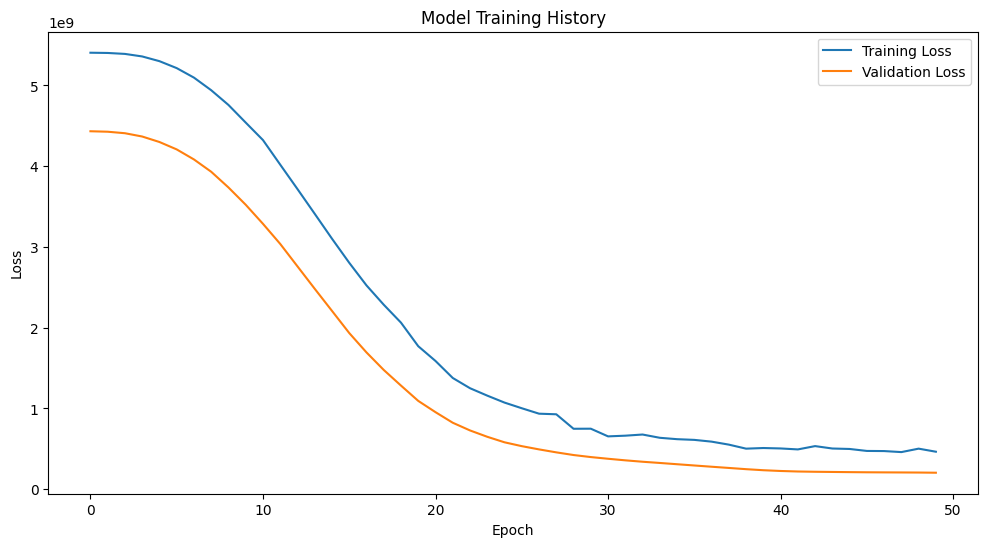

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Historical Trends Analysis

The data is split into BCE and AD periods and analyze the historical trends in built-up area.

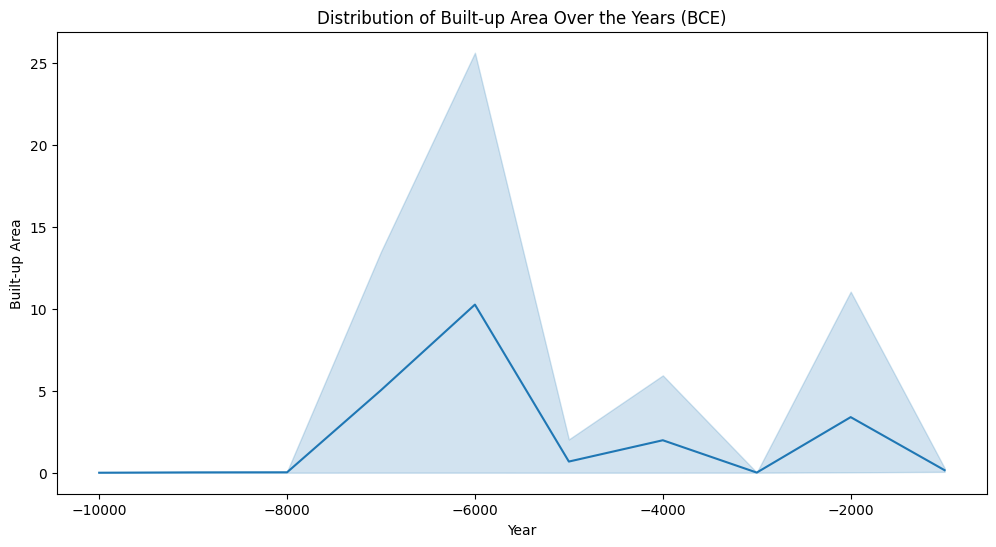

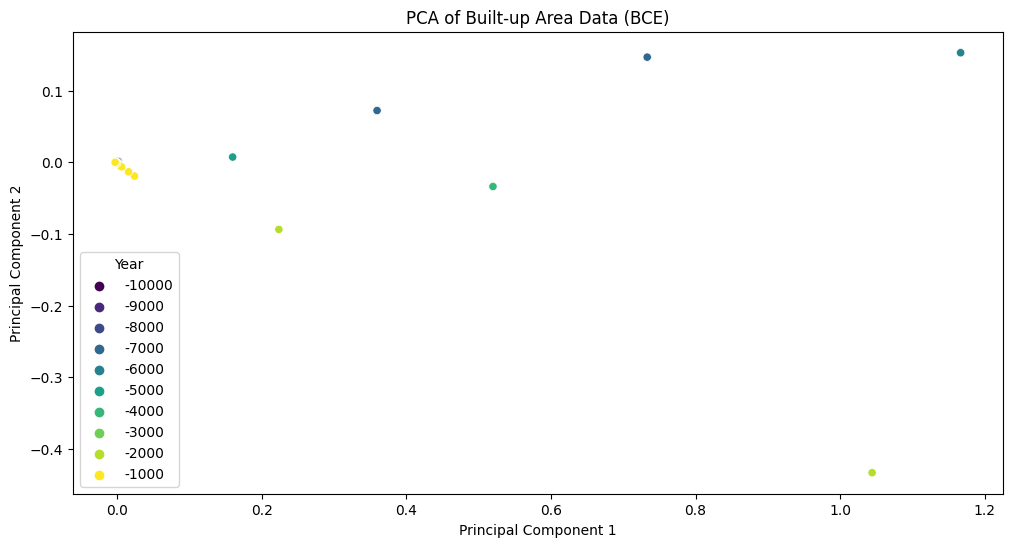

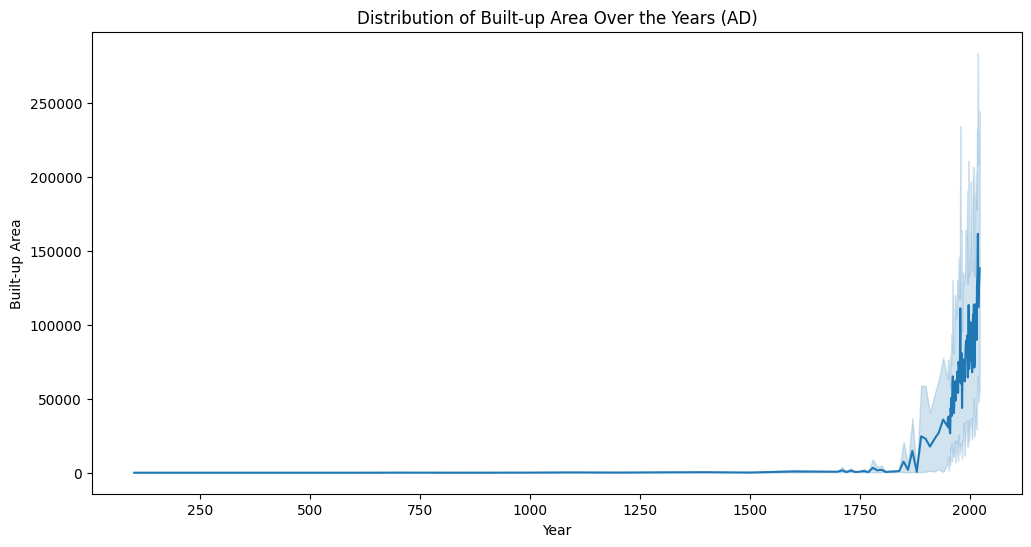

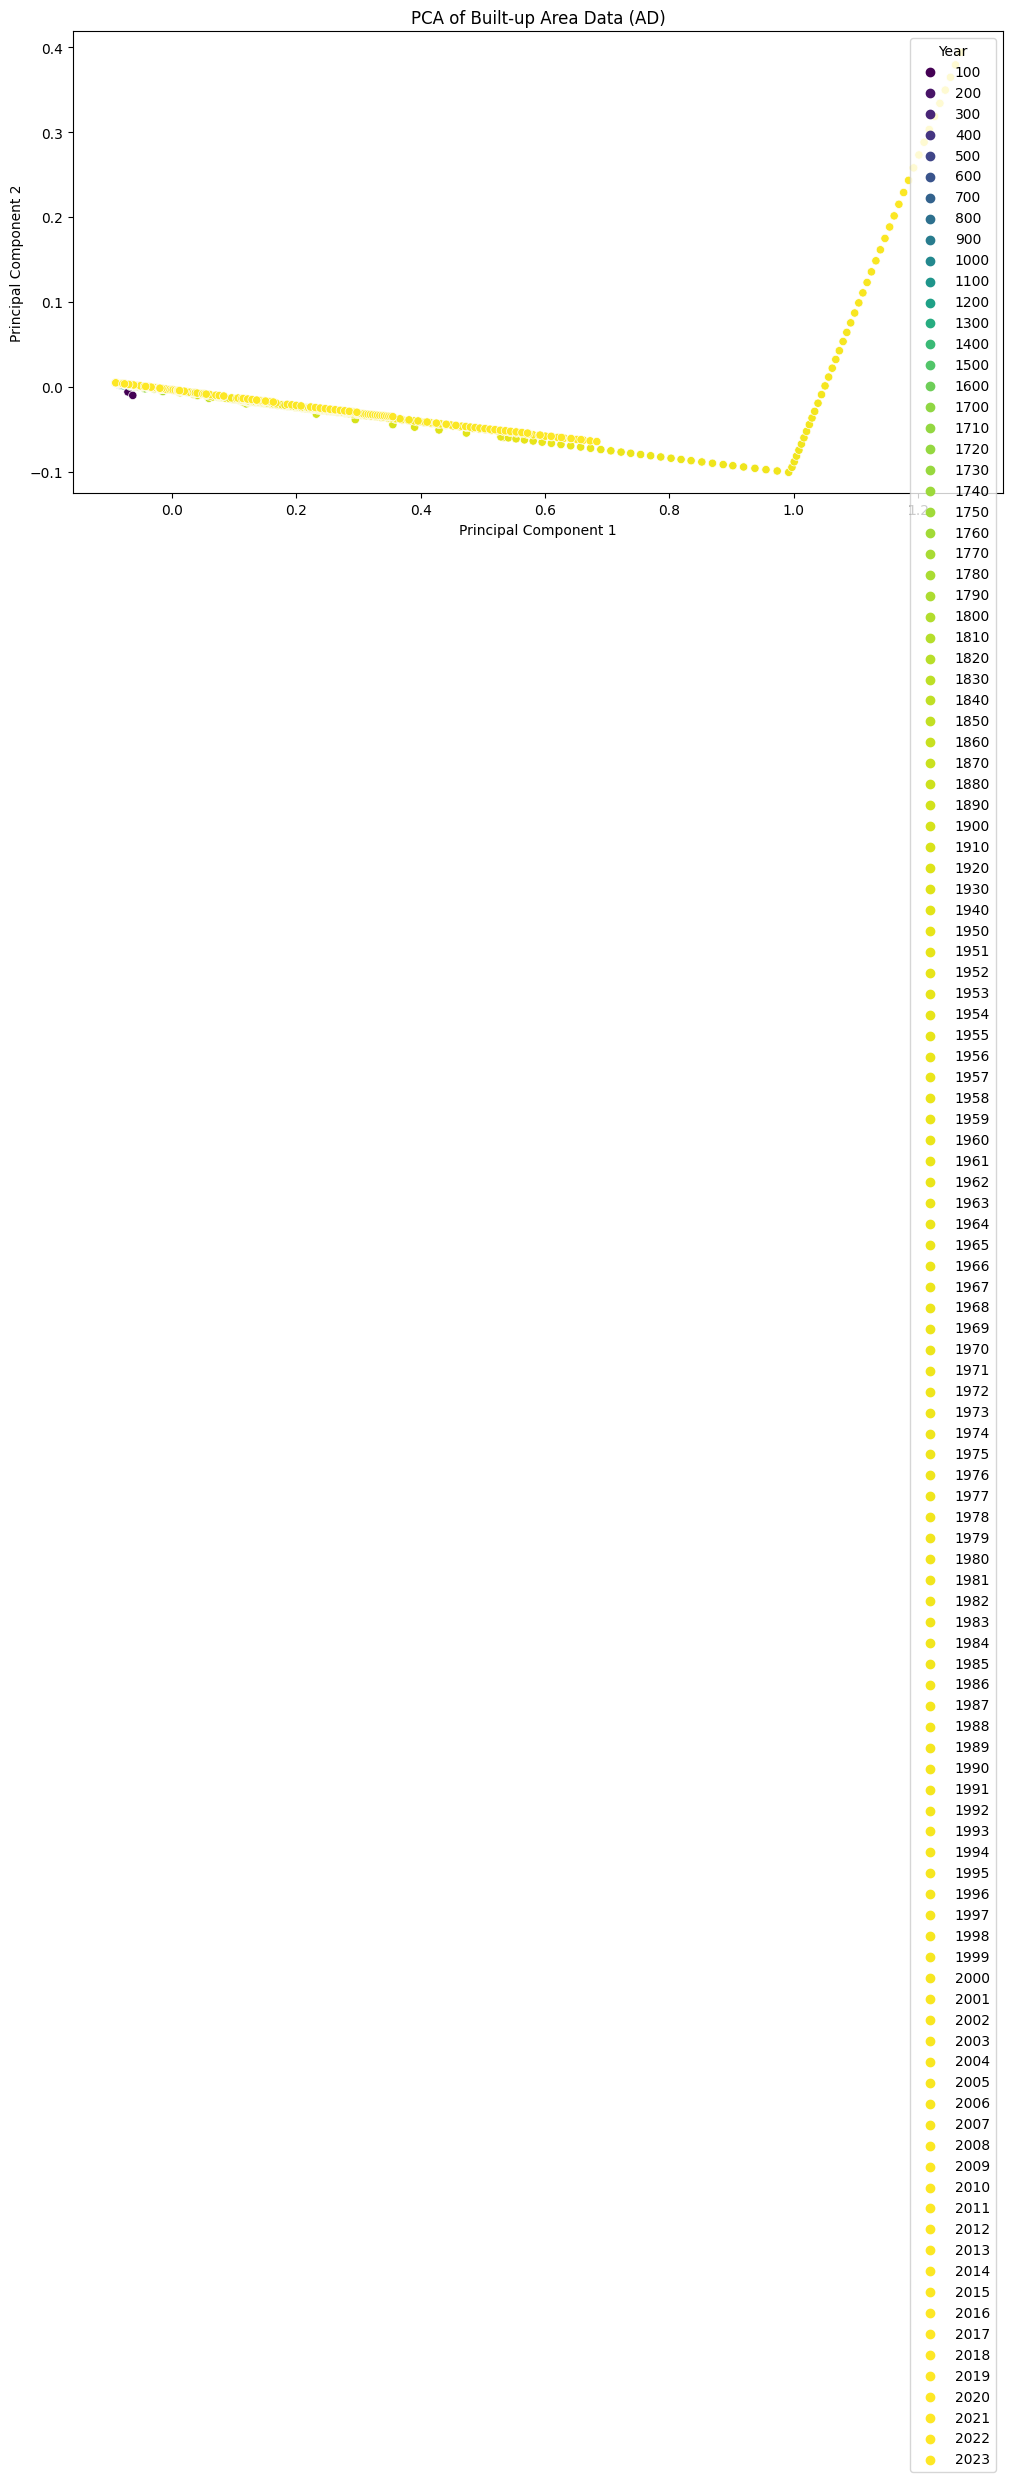

In [16]:
data_bce = data[data['Year'] < 0]
data_ad = data[data['Year'] > 0]

def analyze_trends(data_subset, title_suffix):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Year', y='Land use: Built-up area', data=data_subset)
    plt.title(f'Distribution of Built-up Area Over the Years ({title_suffix})')
    plt.xlabel('Year')
    plt.ylabel('Built-up Area')
    plt.show()

    features = ['Land use: Built-up area', 'Built-up Area per Year']
    x = data_subset[features]
    y = data_subset['Year']

    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(x_scaled)

    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['Year'] = y.values

    plt.figure(figsize=(12, 6))
    scatter = sns.scatterplot(x='PC1', y='PC2', hue='Year', data=pca_df, palette='viridis', legend='full')
    plt.title(f'PCA of Built-up Area Data ({title_suffix})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Year')
    plt.show()

analyze_trends(data_bce, 'BCE')
analyze_trends(data_ad, 'AD')

## Future Trends Predictions using LSTM

LSTM model building to predict future trends in built-up area for both BCE and AD periods.

In [19]:
def prepare_data(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

def predict_future_trend(data, future_years=100):
    data = data.sort_values('Year')
    values = data['Land use: Built-up area'].values.reshape(-1, 1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    values_scaled = scaler.fit_transform(values)
    
    time_step = 10
    X, y = prepare_data(values_scaled, time_step)
    
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    
    model.fit(X, y, epochs=50, batch_size=32, verbose=1)
    
    last_values = values_scaled[-time_step:]
    future_predictions = []
    
    for _ in range(future_years):
        last_values_reshaped = last_values.reshape((1, time_step, 1))
        next_value = model.predict(last_values_reshaped)
        future_predictions.append(next_value[0, 0])
        last_values = np.append(last_values, next_value)[-time_step:]
    
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    
    return future_predictions

future_years = 100

future_bce = predict_future_trend(data_bce, future_years=future_years)
future_ad = predict_future_trend(data_ad, future_years=future_years)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 25)                1275      
                                                                 
 dense_8 (Dense)             (None, 1)                 26        
                                                      

## Combination of Historical and Future Data for Detailed Predictions

In [21]:
def combine_data(data, future_predictions, future_years, is_bce):
    last_year = data['Year'].max() if not is_bce else data['Year'].min()
    future_years_list = range(last_year + 1, last_year + future_years + 1) if not is_bce else range(last_year - 1, last_year - future_years - 1, -1)
    future_df = pd.DataFrame({'Year': future_years_list, 'Predicted Built-up Area': future_predictions.flatten()})
    combined_df = pd.concat([data[['Year', 'Land use: Built-up area']].rename(columns={'Land use: Built-up area': 'Actual Built-up Area'}), future_df], ignore_index=True)
    return combined_df
combined_bce = combine_data(data_bce, future_bce, future_years, is_bce=True)
combined_ad = combine_data(data_ad, future_ad, future_years, is_bce=False)


## Visualization of Combined Data for BCE and AD

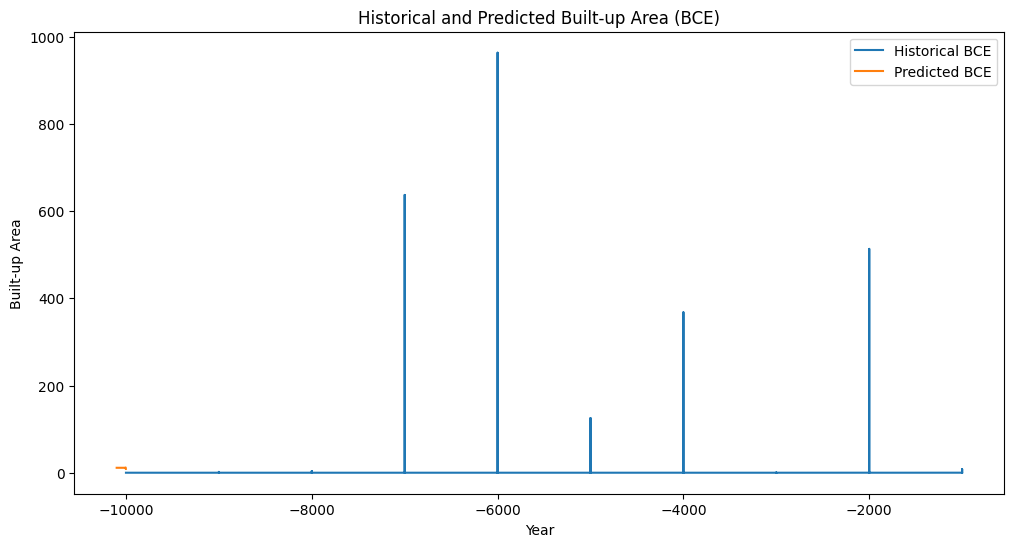

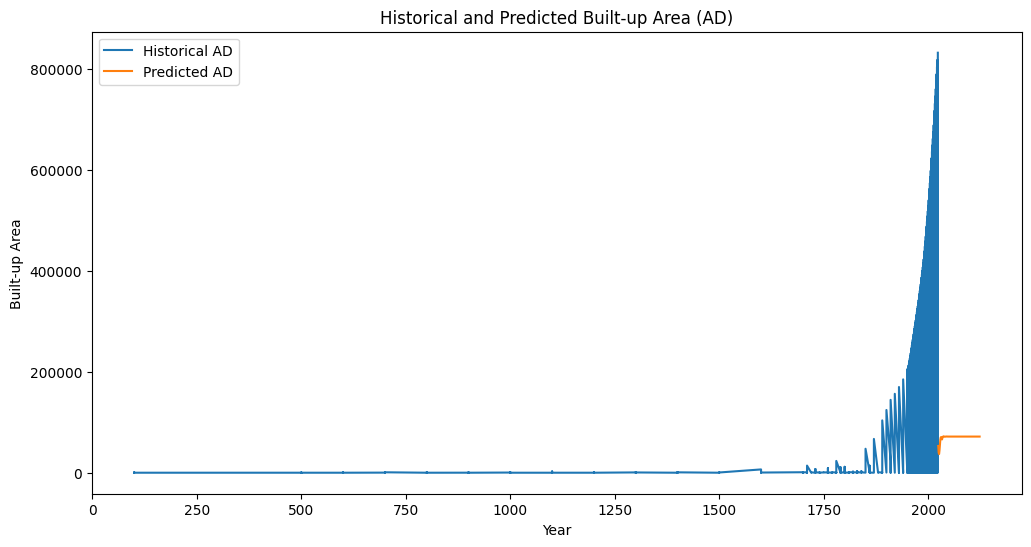

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(combined_bce['Year'], combined_bce['Actual Built-up Area'], label='Historical BCE')
plt.plot(combined_bce['Year'], combined_bce['Predicted Built-up Area'], label='Predicted BCE')
plt.title('Historical and Predicted Built-up Area (BCE)')
plt.xlabel('Year')
plt.ylabel('Built-up Area')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(combined_ad['Year'], combined_ad['Actual Built-up Area'], label='Historical AD')
plt.plot(combined_ad['Year'], combined_ad['Predicted Built-up Area'], label='Predicted AD')
plt.title('Historical and Predicted Built-up Area (AD)')
plt.xlabel('Year')
plt.ylabel('Built-up Area')
plt.legend()
plt.show()


## Conclusion


This notebook contains a comprehensive analysis of the urban area dataset using computer vision techniques and higher-end models.
The data is visualized , Feature engineering performed, PCA conducted, and LSTM models built to predict future built-up area trends.
This analysis provides valuable insights into the trends and patterns in urban development over time, with a focus on separate analyses for BCE and AD periods and future predictions.
    